In [18]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/spotify.csv')  # adjust path if needed

# Preview
print(df.shape)  #Number of rows/columns
print(df.head()) #Sample data
print(df.info())  #Data types and missing values
print(df.describe())  #Summary statistics


(57650, 4)
  artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  
0  Look at her face, it's a wonderful face  \r\nA...  
1  Take it easy with me, please  \r\nTouch me gen...  
2  I'll never know why I had to go  \r\nWhy I had...  
3  Making somebody happy is a question of give an...  
4  Making somebody happy is a question of give an...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0  

In [20]:
print(df['artist'].nunique(), "unique artists")
print(df['song'].nunique(), "unique songs")

643 unique artists
44824 unique songs


In [21]:
df[['artist', 'song']].drop_duplicates().shape[0]  #see song+artist pair if all are unique --> just 2 duplicates so is good for clustering 


57648

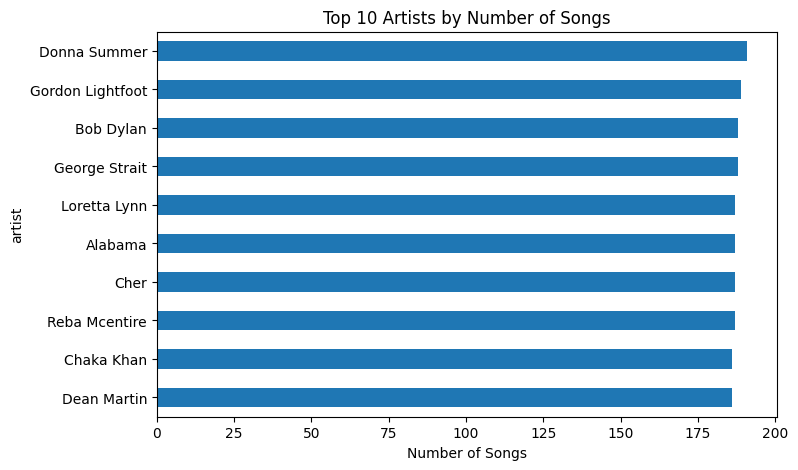

In [22]:
import matplotlib.pyplot as plt

top_artists = df['artist'].value_counts().head(10)
top_artists.plot(kind='barh', figsize=(8,5), title='Top 10 Artists by Number of Songs')
plt.xlabel("Number of Songs")
plt.gca().invert_yaxis()
plt.show()


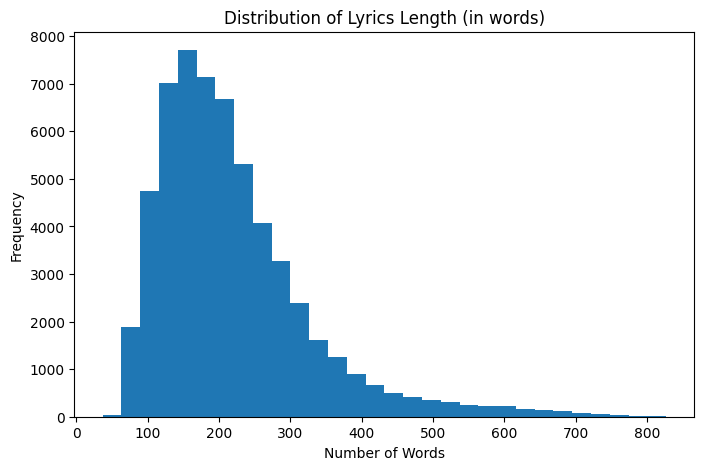

In [23]:
df['lyrics_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['lyrics_length'].plot(kind='hist', bins=30, figsize=(8,5), title='Distribution of Lyrics Length (in words)')
plt.xlabel("Number of Words")
plt.show()


In [ ]:
# Most songs have 100–300 words
# The plot is skewed to the right → most songs are short-to-medium, and a few are much longer.

In [24]:
print(df.isnull().sum())


artist           0
song             0
link             0
text             0
lyrics_length    0
dtype: int64


In [25]:
from collections import Counter
import pandas as pd

# Join all lyrics into one long string and split into words
all_words = ' '.join(df['text'].astype(str)).lower().split()

# Count the top 20 most common words
common_words = Counter(all_words).most_common(20)

# Convert the list of tuples into a DataFrame for easy plotting and display
common_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

print(common_df)



    Word  Frequency
0    the     496517
1      i     418546
2    you     398474
3     to     294849
4    and     292793
5      a     254394
6     me     175910
7     my     168805
8     in     164943
9     of     139358
10    it     137200
11  your     119145
12  that     112507
13    on     105946
14   i'm     104175
15   all      95383
16    is      92314
17    be      90284
18   for      89337
19  love      81532


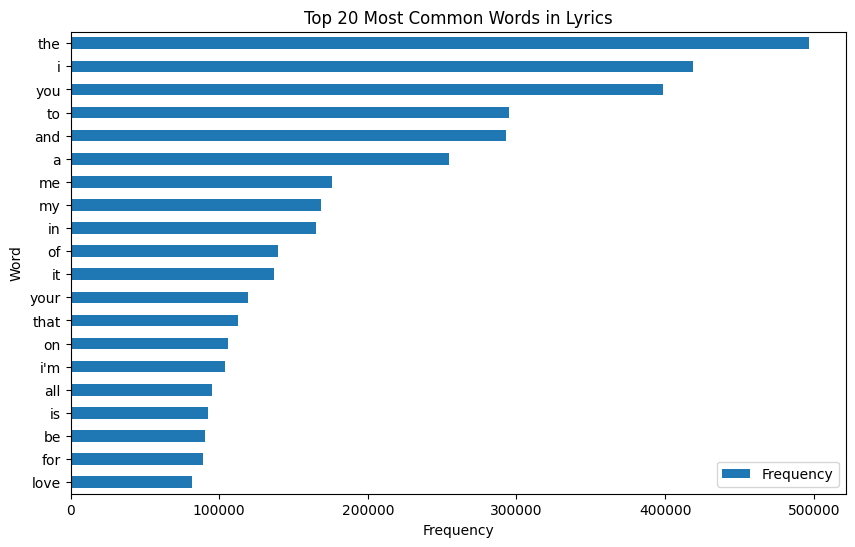

In [26]:
import matplotlib.pyplot as plt

common_df.plot(kind='barh', x='Word', y='Frequency', figsize=(10, 6), title='Top 20 Most Common Words in Lyrics')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.show()


In [27]:
df['lyrics_length'].describe()  #length in words

count    57650.000000
mean       219.486262
std        108.814619
min         37.000000
25%        145.000000
50%        196.000000
75%        264.000000
max        827.000000
Name: lyrics_length, dtype: float64

In [ ]:
# average song in dataset has ~219 words.
# lyrics vary a lot in length, but most are within 100–300 words.

In [28]:
(df['lyrics_length'] < 50).sum()

np.int64(1)

In [31]:
import pandas as pd
import re

# Load the raw dataset
df = pd.read_csv('../data/spotify.csv')

# Create a cleaned copy so you preserve the original
df_cleaned = df.copy()

# Clean the lyrics into a new column
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower()))  #keeps only letters, digits, and whitespace
df_cleaned['cleaned_text'] = df_cleaned['cleaned_text'].str.replace('\n', ' ', regex=False).str.replace('\r', ' ', regex=False)  #multi-line lyrics into one clean line
df_cleaned['cleaned_text'] = df_cleaned['cleaned_text'].str.replace(r'\s+', ' ', regex=True)  #replaces multiple spaces with a single space

# Drop the original 'text' column
df_cleaned.drop(columns=['text'], inplace=True)

# Save the clean version
df_cleaned.to_csv('../data/spotify_cleaned.csv', index=False)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer   #tool that turns text (lyrics) into numerical features based on word importance (TF-IDF).

# Load the cleaned file
df = pd.read_csv('../data/spotify_cleaned.csv')

# Vectorize the cleaned lyrics
#stop_words = the, and, of, is -->removed
#Out of all the words in all songs, just keep the top 2,000 most relevant ones, across all lyrics
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')  
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")

# MATRIX stored in X_tfidf
# Each row = a song
# Each column = one of the top 2,000 words
# Each cell = how important that word is for that song

#TF (term frequency)	How often a word appears in a single song
#IDF (inverse document frequency)	How rare the word is across all songs

# 57,650 songs
# 2,000 important words (features)


TF-IDF matrix shape: (57650, 2000)


In [33]:
import pandas as pd

# Get the feature names ( 2000 words chosen)   --- ["love", "night", "baby", "cry", ...]
feature_names = vectorizer.get_feature_names_out()

# Convert sparse matrix to dense (2D matrix: rows = song, columns = word score=float)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Show first few rows
print(tfidf_df.head())

#0 => each song only uses a small subset of the 2,000 words.

    2x  aah  able  aching  act  acting  action  add  admit  adore  ...   yo  \
0  0.0  0.0   0.0     0.0  0.0     0.0     0.0  0.0    0.0    0.0  ...  0.0   
1  0.0  0.0   0.0     0.0  0.0     0.0     0.0  0.0    0.0    0.0  ...  0.0   
2  0.0  0.0   0.0     0.0  0.0     0.0     0.0  0.0    0.0    0.0  ...  0.0   
3  0.0  0.0   0.0     0.0  0.0     0.0     0.0  0.0    0.0    0.0  ...  0.0   
4  0.0  0.0   0.0     0.0  0.0     0.0     0.0  0.0    0.0    0.0  ...  0.0   

   york  youd     youll  young     youre  youth     youve  yuh  zone  
0   0.0   0.0  0.000000    0.0  0.000000    0.0  0.000000  0.0   0.0  
1   0.0   0.0  0.000000    0.0  0.061484    0.0  0.000000  0.0   0.0  
2   0.0   0.0  0.000000    0.0  0.000000    0.0  0.000000  0.0   0.0  
3   0.0   0.0  0.192000    0.0  0.100713    0.0  0.048493  0.0   0.0  
4   0.0   0.0  0.189959    0.0  0.099642    0.0  0.047978  0.0   0.0  

[5 rows x 2000 columns]


In [35]:
X_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(57650, 2000))

In [36]:
import numpy as np

# Calculate average TF-IDF score for each word(column) across all songs
avg_tfidf = tfidf_df.mean(axis=0)  #axis=0 means average down the row => avg per word => how important that word is on average

# Create DataFrame and sort by score
top_words = avg_tfidf.sort_values(ascending=False).head(20)  #sort high->low avg & select top 20

# Print top 20 most relevant words
print("Top 20 most relevant words based on TF-IDF score:")
print(top_words)


Top 20 most relevant words based on TF-IDF score:
love      0.048569
im        0.047630
dont      0.039239
know      0.035776
just      0.032936
oh        0.031741
like      0.031322
got       0.027285
youre     0.026772
time      0.026066
want      0.025680
baby      0.025406
ill       0.022852
come      0.022550
way       0.021812
say       0.021708
let       0.020851
chorus    0.020559
ive       0.019951
heart     0.019951
dtype: float64


In [ ]:
# The words that most define themes or styles in the dataset

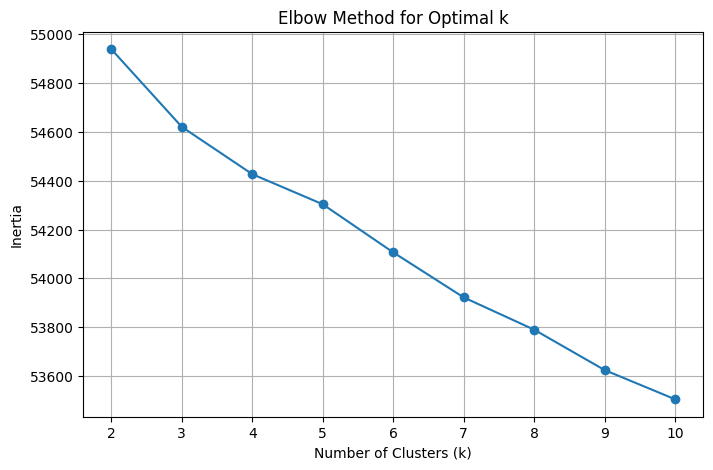

In [37]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Try multiple values of k
inertia = []
k_values = range(2, 11)  # Try from 2 to 10 clusters

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_tfidf)
    inertia.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()


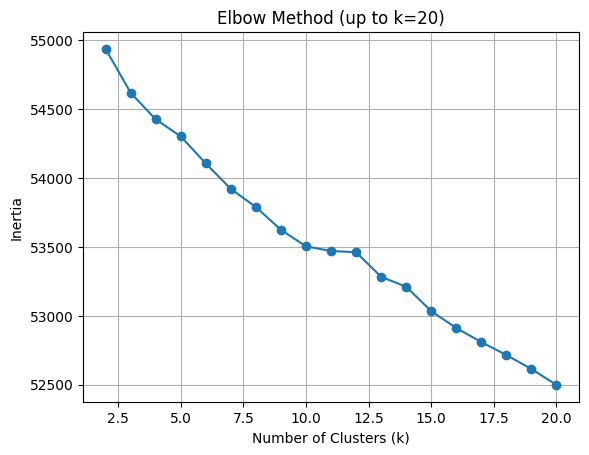

In [38]:
# Try elbow with more clusters
inertia = []
k_range = range(2, 21)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Plot
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method (up to k=20)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [39]:
from sklearn.decomposition import TruncatedSVD

# Reduce dimensions from 2000 to 100 (you can tune this number)
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

print(f"Reduced TF-IDF shape: {X_reduced.shape}")


Reduced TF-IDF shape: (57650, 100)


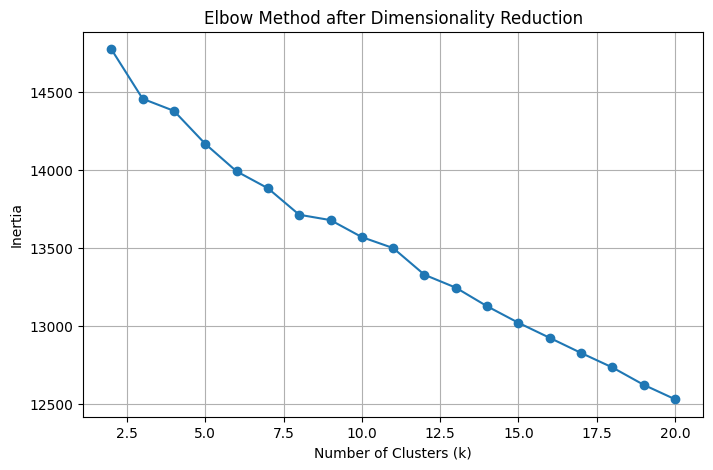

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try different k values
inertias = []
k_values = range(2, 21)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method after Dimensionality Reduction')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [42]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
k = 8  
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_reduced)  # Learn the clusters & Assign cluster labels

# Add the cluster labels to the DataFrame
df['cluster'] = clusters

# Save updated dataset to CSV (with cluster labels)
df.to_csv('../data/spotify_cleaned.csv', index=False)

# Preview the first few results
print(df[['artist', 'song', 'cluster']].head())


# When you fit a model, you're telling it to learn from your data.
# KMeans picks k random centroids (starting points for clusters).
# It then goes through several steps to:
# Assign each data point (song) to the nearest centroid.
# Move each centroid to the average location of the points assigned to it.
# Repeat until the centroids don’t move much anymore (convergence).
# Once the centroids are learned, predict() assigns each point (song) to the closest cluster.


  artist                   song  cluster
0   ABBA  Ahe's My Kind Of Girl        2
1   ABBA       Andante, Andante        1
2   ABBA         As Good As New        6
3   ABBA                   Bang        3
4   ABBA       Bang-A-Boomerang        3


In [43]:
print(df['cluster'].value_counts().sort_index())   #how many songs are in each cluster


cluster
0      414
1    12395
2     6994
3     4621
4      292
5     2479
6    28233
7     2222
Name: count, dtype: int64


In [56]:
print(df[df['cluster'] == 4][['artist', 'song']].head(10))   #print some songs from a specific cluster

              artist                                    song
348    Aiza Seguerra                Huwag Mong Iwan Ang Puso
352    Aiza Seguerra                    Ikaw Ang Aking Mahal
353    Aiza Seguerra          Ikaw Na Ang Bahala: Panalangin
356    Aiza Seguerra                        Pakisabi Na Lang
358    Aiza Seguerra                       Sa Huli Ang Sikat
359    Aiza Seguerra                        Sa Ugoy Ng Duyan
530  Alice In Chains                            Rotten Apple
782    Ariana Grande                                 Why Try
786     Ariel Rivera                     Minamahal Pala Kita
889    Avril Lavigne  All The Small Things (Blink 182 Cover)


In [61]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   #reduces your data from many dimensions to just 2 

# Reduce to 2 components just for plotting
svd_2d = TruncatedSVD(n_components=2, random_state=42)   #reduce dimensionality but for spase matrix
X_2d = svd_2d.fit_transform(X_reduced)

# Plot with colors by cluster
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap='tab10', s=10)
plt.title("KMeans Clusters of Songs (2D View)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.grid(True)
plt.show()


<IPython.core.display.Javascript object>

In [ ]:
%matplotlib notebook


In [60]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Reduce to 3 components for 3D visualization
svd_3d = TruncatedSVD(n_components=3, random_state=42)
X_3d = svd_3d.fit_transform(X_reduced)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
    c=df['cluster'], cmap='tab10', s=8
)

# Labels and title
ax.set_title("KMeans Clusters of Songs (3D View)")
ax.set_xlabel("SVD Component 1")
ax.set_ylabel("SVD Component 2")
ax.set_zlabel("SVD Component 3")

plt.show()


<IPython.core.display.Javascript object>

In [49]:
for i in range(k):
    print(f"\nTop words in Cluster {i}:")
    cluster_indices = df[df['cluster'] == i].index
    cluster_tfidf = tfidf_df.iloc[cluster_indices]
    top_words = cluster_tfidf.mean().sort_values(ascending=False).head(10)
    print(top_words)



Top words in Cluster 0:
ooh      0.444575
oh       0.053621
yeah     0.049607
love     0.049518
baby     0.048545
im       0.048366
dont     0.037742
know     0.032093
youre    0.031334
want     0.030697
dtype: float64

Top words in Cluster 1:
im       0.099519
dont     0.093296
know     0.071614
want     0.060165
just     0.054688
youre    0.051612
ill      0.040742
like     0.038232
say      0.038150
time     0.037414
dtype: float64

Top words in Cluster 2:
got      0.105906
im       0.070615
yeah     0.070409
aint     0.058595
like     0.053830
hey      0.043991
dont     0.039024
shes     0.038254
gonna    0.037767
know     0.035643
dtype: float64

Top words in Cluster 3:
love     0.301691
heart    0.045679
know     0.045547
im       0.044434
dont     0.036675
just     0.036106
ill      0.031767
need     0.030605
like     0.030522
oh       0.030473
dtype: float64

Top words in Cluster 4:
na     0.586366
ang    0.170791
sa     0.133430
ko     0.106484
ng     0.072306
ka     0.069965

In [ ]:
# Cluster	Top Words	Likely Theme
# 0	ooh, yeah, love, baby, im	🎶 Romantic pop / R&B – emotional, intimate lyrics
# 1	im, dont, know, want, just	💬 Reflective / Confessional – internal thoughts, personal struggles
# 2	got, yeah, aint, hey, gonna	🔥 Rap / Energetic pop – casual, expressive, upbeat tone
# 3	love, heart, need, oh	❤️ Classic love ballads – emotional love-centered tracks
# 4	na, sa, ko, ng, mo	🌏 Non-English songs (likely Filipino/Tagalog)
# 5	baby, love, oh, come	💘 Dance/R&B – repeated catchy terms, flirtatious tone
# 6	time, come, day, away, night	🌄 Reflective / Life journey – storytelling, passing time
# 7	oh, yeah, love, come	🎤 Soulful / expressive pop – emotive interjections, expressive lyrics